In [1]:
from time import time

import pymc3 as pm
import theano
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

from bayesumis.umis_math_model import UmisMathModel
from bayesumis.umis_diagram import UmisDiagram
from testhelper.test_helper import end_timer, DbStub
from testhelper import umis_builders
from testhelper.posterior_plotters import compare_plots, display_parameters, print_umis_diagram

theano.config.mode = 'FAST_RUN'
theano.config.optimizer = 'fast_compile'

test_db = DbStub()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# (external_inflows,
#  internal_flows,
#  external_outflows,
#  stocks) = umis_builders.get_umis_diagram_basic()

(external_inflows,
 internal_flows,
 external_outflows,
 stocks,
 material_reconc_table,
 tc_obs) = umis_builders.get_umis_diagram_lognormal_and_normal_test()

internal_stafs = set.union(internal_flows, stocks)

print("Building UmisDiagram...")
start_time = time()

umis_diagram = UmisDiagram(
    external_inflows,
    internal_stafs,
    external_outflows)

end_timer(start_time)

ref_material = test_db.get_material_by_num(1)
ref_time = test_db.get_time_by_num(1)

res_inflows = umis_diagram.get_external_inflows()
res_outflows = umis_diagram.get_external_outflows()
res_dict = umis_diagram.get_process_stafs_dict()

Model built Tue 12:36
Building UmisDiagram...
Task finished, time elapsed: 0.00016117095947265625


In [3]:
print_umis_diagram(res_inflows, res_dict, res_outflows)

Staf: Flow 1 & 2, ID: F1


Process: Process 1, STAFDB ID: P2
Staf: Flow 3, ID: F2
stock: None

Process: Process 2, STAFDB ID: P3
Staf: Flow 4, ID: F3
Staf: Flow 5, ID: F4
stock: None

Process: Process 3, STAFDB ID: P4
stock: None





In [4]:
print("Building math model...")
start_time = time()
math_model = UmisMathModel(
    res_inflows,
    res_dict,
    res_outflows,
    ref_material,
    ref_time,
    material_reconc_table,
    tc_obs)

end_timer(start_time)


Building math model...


/home/tom/anaconda3/envs/bayesian-umis/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/bayesian-umis/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/bayesian-umis/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

Task finished, time elapsed: 7.447186231613159


In [5]:
sample_size = 3000

print("Sampling {} times from math model".format(sample_size))
start_time = time()

with math_model.pm_model:
    trace = pm.sample(sample_size, init='adapt_diag')

end_timer(start_time)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


Sampling 3000 times from math model


/home/tom/anaconda3/envs/bayesian-umis/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/bayesian-umis/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/bayesian-umis/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

Task finished, time elapsed: 56.96798133850098


In [6]:
map_estimate = pm.find_MAP(model=math_model.pm_model)

/home/tom/.local/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/home/tom/anaconda3/envs/bayesian-umis/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/bayesian-umis/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

Estimates of: External Inflows

Input Flow: Flow 1 & 2: 145.5332335513025


Estimates of: Internal Stafs

TC: Flow 3: 1.0
Internal Staf: Flow 3: 299.99999119030997
TC: Flow 4: 0.5148892072500727
Internal Staf: Flow 4: 154.46675763900748
TC: Flow 5: 0.4851107927499273
Internal Staf: Flow 5: 145.5332335513025


Estimates of: External Outflows





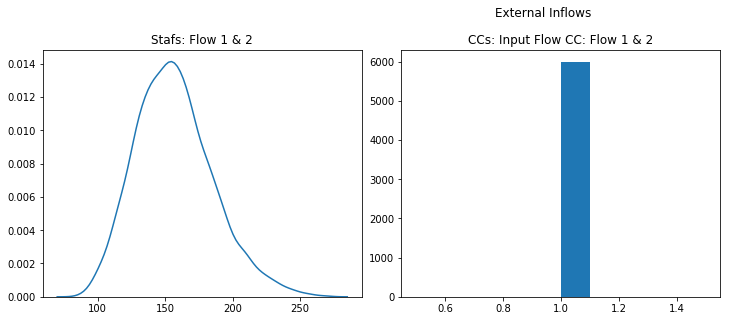

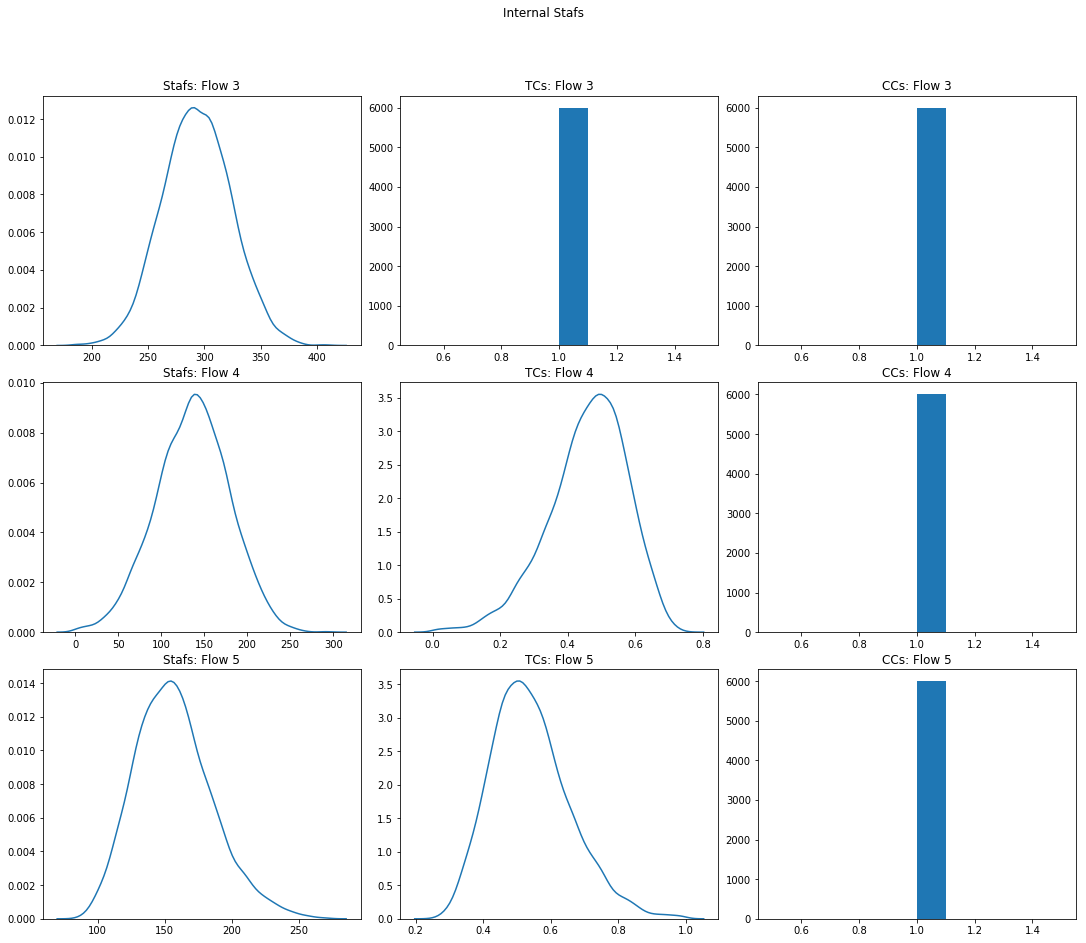

<Figure size 1080x0 with 0 Axes>

In [7]:
display_parameters(external_inflows, internal_stafs, external_outflows, trace, map_estimate, math_model)
# display_parameters(external_inflows, internal_stafs, external_outflows, trace, {}, math_model)


In [8]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
P_P2_Sp1__0,1.000000,0.000000,0.000000,1.000000,1.000000,NaN,NaN
P_P3_Sp1__0,0.459066,0.116450,0.003025,0.231916,0.672991,1264.859794,0.999994
P_P3_Sp1__1,0.540934,0.116450,0.003025,0.327009,0.768084,1264.859794,0.999994
TCs__0_0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
TCs__0_1,1.000000,0.000000,0.000000,1.000000,1.000000,NaN,NaN
TCs__0_2,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
TCs__1_0,0.459066,0.116450,0.003025,0.231916,0.672991,1264.859794,0.999994
TCs__1_1,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
TCs__1_2,0.540934,0.116450,0.003025,0.327009,0.768084,1264.859794,0.999994
TCs__2_0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN


In [11]:

flow_1_2_data = trace['Inputs'][:, 1, 0]
flow_3_data = trace['Stafs'][:, 1, 0]
flow_4_data = trace['Stafs'][:, 0, 1]
flow_5_data = trace['Stafs'][:, 0, 2]
tc_21_data = trace['TCs'][:, 0, 1]
tc_23_data = trace['TCs'][:, 0, 2]

flow_1_2_sd = np.std(np.log(flow_1_2_data))
# flow_5_s#d = np.std(np.log(flow_5_data))

# print(flow_5_sd)

In [12]:
with pm.Model() as priors_model:
    flow_1_2_prior = pm.Lognormal('flow_1_2_prior', np.log(150), 0.25)
    flow_3_prior = pm.Normal('flow_3_prior', 300, 30)
    flow_4_prior = pm.Uniform('flow_4_prior', 0, 1000)    
    flow_5_prior = pm.Lognormal('flow_5_prior', np.log(160), 0.25)   
    tc_priors = pm.Dirichlet('tc_priors', np.array([1, 1]))
    trace_prior = pm.sample(5000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tc_priors, flow_5_prior, flow_4_prior, flow_3_prior, flow_1_2_prior]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:13<00:00, 791.71draws/s]


In [13]:
flow_1_2_prior = trace_prior['flow_1_2_prior']
flow_3_prior = trace_prior['flow_3_prior']
flow_4_prior = trace_prior['flow_4_prior']
flow_5_prior = trace_prior['flow_5_prior']
tc_21_prior = trace_prior['tc_priors'][0]
tc_23_prior = trace_prior['tc_priors'][1]

In [14]:
pairs = [
    (flow_1_2_prior, flow_1_2_data),
    (flow_3_prior, flow_3_data),
    (flow_4_prior, flow_4_data),
    (flow_5_prior, flow_5_data),
    (tc_21_prior, tc_21_data),
    (tc_23_prior, tc_23_data), 
]

titles = [
    'Flow 1 & 2',
    'Flow 3',
    'Flow 4',
    'Flow 5',
    'TC Flow 4',
    'TC Flow 5'
]

In [15]:
import seaborn as sns

In [16]:
def compare_plots(pairs, titles):
    for i, (prior, posterior) in enumerate(pairs):
        fig = plt.figure(facecolor='w')
        ax = sns.kdeplot(prior, color='b')
        ax = sns.kdeplot(posterior, color='r', ax=ax)
        fig.suptitle(titles[i])
    plt.show()

In [18]:
# compare_plots(pairs, titles)

In [19]:
accept = trace.get_sampler_stats('mean_tree_accept')
print(accept.mean())

0.8533692212975399
